In [1]:
!pip install scikit-optimize

In [40]:
import sys
pasta_projeto = '/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Airbnb Open Data'
sys.path.append(pasta_projeto)

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from skopt import forest_minimize

from lightgbm import LGBMClassifier

import joblib as jb

from utils import Utils

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [42]:
pasta_dados = pasta_projeto+'/data'

In [43]:
dados = pd.read_csv(pasta_dados+'/dados_final.csv', index_col=0)
dados.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,neighbourhood_labels
id,,,,,,,,,,,
21280,442,5,94,1.23,90,1,1,0,0,0,9
48726,105,3,42,1.35,90,1,0,0,1,0,3
48901,548,4,4,0.07,348,1,1,0,0,0,3
50294,1206,3,72,0.67,322,5,1,0,0,0,9
60718,1084,7,8,0.07,240,2,1,0,0,0,3


In [44]:
dados.dtypes

price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
availability_365                    int64
calculated_host_listings_count      int64
Entire home/apt                     int64
Hotel room                          int64
Private room                        int64
Shared room                         int64
neighbourhood_labels                int64
dtype: object

In [45]:
dados._get_numeric_data().describe()[1:]

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,neighbourhood_labels
mean,416.623642,3.609459,7.602607,0.319503,168.019728,2.689964,0.690633,0.004653,0.280651,0.024062,4.929853
std,387.715722,4.279613,15.851824,0.581797,154.543320,3.939019,0.462240,0.068056,0.449325,0.153245,2.366210
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,277.000000,2.000000,1.000000,0.070000,143.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
75%,525.000000,4.000000,6.000000,0.360000,362.000000,2.000000,1.000000,0.000000,1.000000,0.000000,6.000000
max,2000.000000,30.000000,100.000000,8.490000,365.000000,30.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [85]:
scaler = MinMaxScaler(feature_range=(0,1))
columns = ['minimum_nights',	'number_of_reviews',	'reviews_per_month',	'availability_365',	'calculated_host_listings_count',	'Entire home/apt',	'Hotel room',	'Private room',	'Shared room']
transform = scaler.fit_transform(dados[columns])

In [86]:
dados_n = pd.concat([pd.DataFrame(transform, index=dados.index, columns=columns), dados[['price', 'neighbourhood_labels']]], axis=1)
dados_n.head()

,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,price,neighbourhood_labels
id,,,,,,,,,,,
21280,0.137931,0.94,0.144876,0.246575,0.000000,1.0,0.0,0.0,0.0,442,9
48726,0.068966,0.42,0.159011,0.246575,0.000000,0.0,0.0,1.0,0.0,105,3
48901,0.103448,0.04,0.008245,0.953425,0.000000,1.0,0.0,0.0,0.0,548,3
50294,0.068966,0.72,0.078916,0.882192,0.137931,1.0,0.0,0.0,0.0,1206,9
60718,0.206897,0.08,0.008245,0.657534,0.034483,1.0,0.0,0.0,0.0,1084,3


In [48]:
train = int(dados.shape[0]*0.99)
valid = int(dados.shape[0]*0.01)

if (train+valid)!=dados.shape[0]:
  valid+=1


print('Values okay {}'.format((train+valid)==dados.shape[0]))
print("Number training values: {} \nNumber valid values: {}".format(train,valid))

Values okay True
Number training values: 31063 
Number valid values: 314


In [49]:
valores_gerais = [i for i in range(0, dados.shape[0])]
valores_gerais[:5]

[0, 1, 2, 3, 4]

In [50]:
valores_gerais = [i for i in range(0, dados.shape[0])]
train = random.choice(valores_gerais, train)
valid = random.choice(valores_gerais, valid)

In [51]:
#np.save(pasta_dados+'/train.npy', train)
#np.save(pasta_dados+'/valid.npy', valid)

In [52]:
with open(pasta_dados+'/train.npy', 'rb') as f:
    train = np.load(f)
f.close()
with open(pasta_dados+'/valid.npy', 'rb') as f:
    valid = np.load(f)
f.close()

In [53]:
train = dados_n.iloc[train]
valid = dados_n.iloc[valid]

In [54]:
train.head()

,minimum_nights,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,Entire home/apt,Hotel room,Private room,Shared room,price,neighbourhood_labels
id,,,,,,,,,,,
10757209,0.000000,0.00,0.000000,1.000000,0.000000,1.0,0.0,0.0,0.0,1924,6
13798162,0.310345,0.00,0.000000,1.000000,0.172414,1.0,0.0,0.0,0.0,999,6
42717550,0.068966,0.00,0.000000,0.997260,0.137931,1.0,0.0,0.0,0.0,597,3
32060355,0.034483,0.01,0.037691,0.246575,0.000000,0.0,0.0,1.0,0.0,77,3
22541482,1.000000,0.00,0.000000,1.000000,0.034483,0.0,0.0,1.0,0.0,115,9


In [55]:
X_train, y_train = train.drop('neighbourhood_labels', axis=1), train['neighbourhood_labels']
X_valid, y_valid = valid.drop('neighbourhood_labels', axis=1), valid['neighbourhood_labels']

In [69]:
model = DecisionTreeClassifier(random_state=0, max_depth=int(dados.shape[0]), class_weight="balanced")
model.fit(X_train, y_train)
predict = model.predict(X_valid)
print(Utils.multiclass_roc_auc_score(y_valid.values, predict))

0.8215109727141043


In [70]:
classes = pd.read_csv(pasta_dados+'/vizinhanca.csv', index_col=0)
classes = classes.values
classes = np.reshape(classes, (len(classes),))

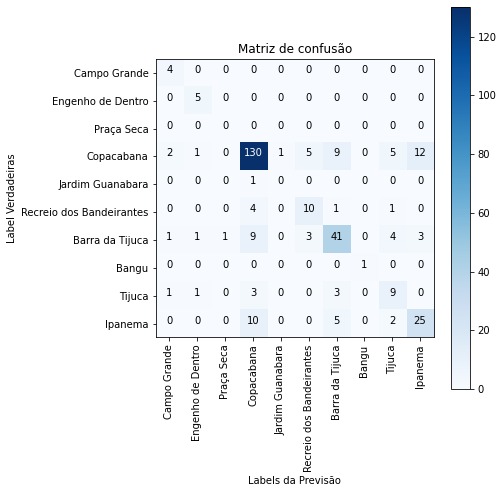

In [71]:
confusion = confusion_matrix(y_true = y_valid.values, 
                             y_pred = predict)
Utils.plot_confusion_matrix(cm = confusion, classes = classes, title = 'Matriz de confusão')

In [72]:
model = RandomForestClassifier(random_state=0,
                               n_estimators=100,
                               n_jobs=-1)

model.fit(X_train, y_train)
predict_rf = model.predict(X_valid)
print(Utils.multiclass_roc_auc_score(y_valid.values, predict_rf))

0.7747802362773739


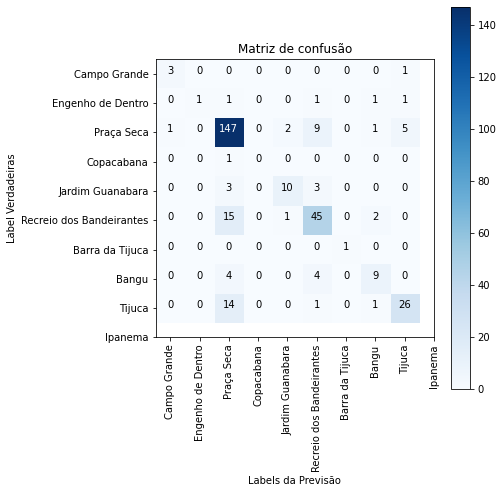

In [73]:
confusion = confusion_matrix(y_true = y_valid.values, 
                             y_pred = predict_rf)
Utils.plot_confusion_matrix(cm = confusion, classes = classes, title = 'Matriz de confusão')

In [64]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = -1
    n_estimators = params[1]
    
    mdl = LGBMClassifier( random_state=0, 
                          class_weight="balanced", 
                          n_jobs=-1,
                          max_depth=-1,
                          n_estimators = n_estimators,
                          learning_rate = lr)
    mdl.fit(X_train, y_train)
    
    p = mdl.predict(X_valid)
    
    print(accuracy_score(y_valid.values, p))
    return accuracy_score(y_valid.values, p)


space = [(1e-1, 6e-1, 'log-uniform'), # lr
          (2000,6000)] # n_estimators

res = forest_minimize(tune_lgbm, 
                      space, 
                      random_state=0, 
                      n_random_starts=5, 
                      n_calls=10, 
                      verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.2892829122744809, 5264]
0.732484076433121
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 151.6527
Function value obtained: 0.7325
Current minimum: 0.7325
Iteration No: 2 started. Evaluating function at random point.
[0.2944700124966295, 3731]
0.732484076433121
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 107.7607
Function value obtained: 0.7325
Current minimum: 0.7325
Iteration No: 3 started. Evaluating function at random point.
[0.45634153606906336, 5795]
0.7292993630573248
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 171.4221
Function value obtained: 0.7293
Current minimum: 0.7293
Iteration No: 4 started. Evaluating function at random point.
[0.31812903763285566, 3828]
0.732484076433121
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 116.2296
Function value obtained: 0.7325
Current minimum: 0.7293
Iteration No: 5 started. Evaluating f

In [74]:
model = LGBMClassifier(random_state=0, 
                       class_weight="balanced", 
                       n_jobs=-1,
                       max_depth=-1,
                       n_estimators = 5264,
                       learning_rate = 0.2892829122744809)
model.fit(X_train, y_train)
predict_l = model.predict(X_valid)
Utils.multiclass_roc_auc_score(y_valid.values, predict_l)

0.8268489043842187

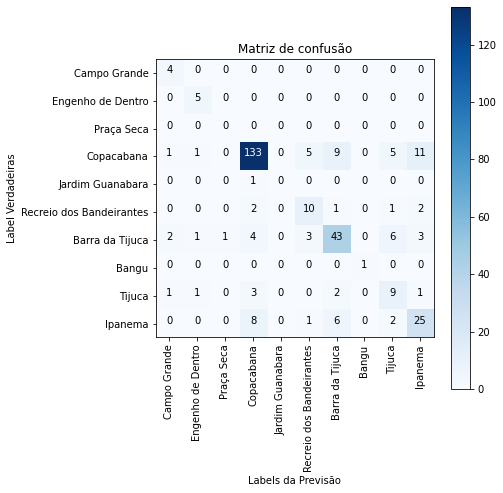

In [75]:
confusion = confusion_matrix(y_true = y_valid.values, 
                             y_pred = predict_l)
Utils.plot_confusion_matrix(cm = confusion, classes = classes, title = 'Matriz de confusão')

In [76]:
print(classification_report(y_valid.values, predict_l))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         0
           3       0.88      0.81      0.84       165
           4       0.00      0.00      0.00         1
           5       0.53      0.62      0.57        16
           6       0.70      0.68      0.69        63
           7       1.00      1.00      1.00         1
           8       0.39      0.53      0.45        17
           9       0.60      0.60      0.60        42

    accuracy                           0.73       314
   macro avg       0.52      0.62      0.56       314
weighted avg       0.75      0.73      0.74       314



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
jb.dump(model, pasta_projeto+"/modelo_lgbm.pkl.z")

['/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Airbnb Open Data/modelo_lgbm.pkl.z']

In [81]:
scaler = MinMaxScaler(feature_range=(0,1))
columns = ['minimum_nights',	'number_of_reviews',	'reviews_per_month',	'availability_365',	'calculated_host_listings_count',	'Entire home/apt',	'Hotel room',	'Private room',	'Shared room']
minmax_dados = scaler.fit(dados[columns])

In [95]:
jb.dump(minmax_dados, pasta_projeto+"/minmax_dados.pkl.z")

['/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Airbnb Open Data/minmax_dados.pkl.z']

In [96]:
np.save(pasta_projeto+'/columns.npy', columns)

In [98]:
with open(pasta_projeto+'/columns.npy', 'rb') as f:
    columns = np.load(f)
f.close()
columns

array(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'availability_365', 'calculated_host_listings_count',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room'],
      dtype='<U30')